In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torch.autograd import Variable
from torch.backends import cudnn


import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np


# Augmenting library 

import torchvision
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"
print(torch.cuda.device_count())


# logging
import datetime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time 

/home/sklab2/anaconda3/envs/vessel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2


In [3]:
import joint_transforms
from config import cod_training_root
from config import backbone_path
from datasets import ImageFolder
from misc import AvgMeter, check_mkdir
from PFNet import PFNet
from helper import *
import loss

# Config

In [4]:
ckpt_path = './ckpt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'epoch_num': 200,
    'train_batch_size': 32,
    'last_epoch': 0,
    'lr': 1e-3, 
    'lr_decay': 0.9,
    'weight_decay': 1e-3,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416, 
    'save_point': [],
    'poly_train': False,
    'optimizer': 'Adam',
    'amp' : False
}

In [5]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 -   ( (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))  )
    return loss.mean()


def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

# Net

In [6]:
from SA_Unet import SA_UNet

net = SA_UNet(in_channels=3, num_classes=1 , base_c=16).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=40, verbose=True)

## making data index list

In [7]:
mask_files = os.walk("/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked")
mask_idx = []
for (root, dirs, files) in mask_files:
    if len(files) > 0 :
        mask_idx.append(files)

mask_idxs = [element for array in mask_idx for element in array]
len(mask_idxs)

1691

In [8]:
# 1~ 11 / 12, 13, 14  , 40, 41, 43, 44, 46, 49,  50, 53, 54, 55 
train_indexs = []
test_indexs = []
for idx, data in enumerate(mask_idxs):
    tmp = mask_idxs[idx].split('_')
    if len(tmp) < 3:
        if int(tmp[0]) < 45:
            train_indexs.append([ tmp[0], tmp[1].split('.')[0]])
        else:
            test_indexs.append([tmp[0], tmp[1].split('.')[0]])

In [9]:
len(train_indexs) , len(test_indexs)

(1319, 355)

# Dataloader

In [10]:
import albumentations.augmentations.functional as AF

PATH = '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/'
class VesselDataset(Dataset):
    def __init__(self, index, transforms):
        self.index = index
        self.transforms = transforms
        
    def __len__(self):
        return len(self.index)
        
    def __getitem__(self, idx):
        s_1 = self.index[idx][0]
        s_2 = self.index[idx][1]

        # '1_L_0.jpg', 
        image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').resize((416, 416),Image.Resampling.BILINEAR)
        #'10_L_112_L.png', 
        mask = Image.open(PATH+'masked/' +  s_1+'_'+s_2+'.png').resize((416, 416),Image.Resampling.BILINEAR)
        
        image = np.array(image, dtype=np.uint8) #RGB
        mask = np.array(mask, dtype=np.uint8)   # HWC
        mask_o = mask / 255        # CHW

        lower_red = np.array([-10, 100, 100]) 
        upper_red = np.array([10, 255, 255]) 

        mask_hsv = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(mask_hsv, lower_red, upper_red)

        aft_mask = mask / 255
        
        # aft_mask = cv2.resize(aft_mask, (416, 416), interpolation=cv2.INTER_NEAREST)
        masks = [aft_mask, mask_o]  # target, original

        # for num in range(3): #### 3번 이터레이션이 왜들어갔지?
        if self.transforms:
            transformed = self.transforms(image=image, masks=masks)
            image, masks = transformed['image'], transformed['masks']
        # urls.append(s_1+'_'+s_2)
        assert sum(masks[0]==0).sum() + sum(masks[0]==1).sum() == 416*416   # mask가 0 또는 1이 아닐경우 스탑
                    
        return image, masks, aft_mask, s_1+'_'+s_2

In [11]:
import albumentations.pytorch as AP

transforms = A.Compose([      
    A.Resize(416, 416, interpolation=cv2.INTER_NEAREST),
    # A.RandomRotate90(p=0.3),
    # A.HorizontalFlip(p=0.3),

    # A.OneOf([
    #     A.OpticalDistortion(),
    #     A.GridDistortion(),
    #     A.ElasticTransform(),
    #     ], p = 0.3),
    # A.OneOf([
    #     A.CLAHE(clip_limit = 2),
    #     A.RandomBrightnessContrast(),
    #     ], p = 0.3),

    # A.Equalize(p=1.0),
    # A.CLAHE(always_apply=True), # 위에 추가하고 
    #transforms.RandomCrop((420, 420)) , 
    #transforms.RandomVerticalFlip(p=1), 
    # A.Normalize(mean=(126.8661, 126.8530, 127.0134), std = (32.9434, 33.0122, 32.9186)),
    AP.ToTensorV2(always_apply=True)
    #!!!
])

# tensor([127.5388, 127.5482, 127.6733])
# tensor([57.4250, 57.6999, 57.5387])
train_dataset = VesselDataset(index=train_indexs, transforms=transforms)
test_dataset = VesselDataset(index=test_indexs, transforms=transforms)
 
#train_dataset, _, test_dataset = torch.utils.data.random_split(dataset, [train, 0, test])

train_loader = DataLoader(dataset=train_dataset, batch_size=args['train_batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

image, masks, aft_mask, _= next(iter(train_loader))
print(image.shape, masks[0].shape, masks[1].shape, aft_mask.shape)

torch.Size([32, 3, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 416, 416, 3]) torch.Size([32, 416, 416])


In [12]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
def calc_metric(labels, preds):
    accuracy = np.mean(np.equal(labels,preds))
    right = np.sum(labels *preds == 1)
    precision = right / np.sum(preds)
    recall = right / np.sum(labels)
    f1 = 2 * precision*recall/(precision+recall)

    
    y_pred = preds
    y_true = labels
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)
    print('jaccard, f1, recall, precision, acc')
    print(score_jaccard, score_f1, score_recall, score_precision, score_acc)
    return score_jaccard, score_f1, score_recall, score_precision, score_acc

# Train

Using 2 GPUs.
SA_Unet_b32_e200_js_220930_15:31
../model/vessel_SA_Unet_b32_e200_220930_15:31.pt
Training 200 epochs.


100%|██████████| 42/42 [01:51<00:00,  2.65s/it, Epoch=0, Loss=0.756145, Mean Loss=0.804296, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.27890749987997515 0.4361652424528756 0.8239491428174384 0.29658180873081036 0.8063711852289774
Model Saved


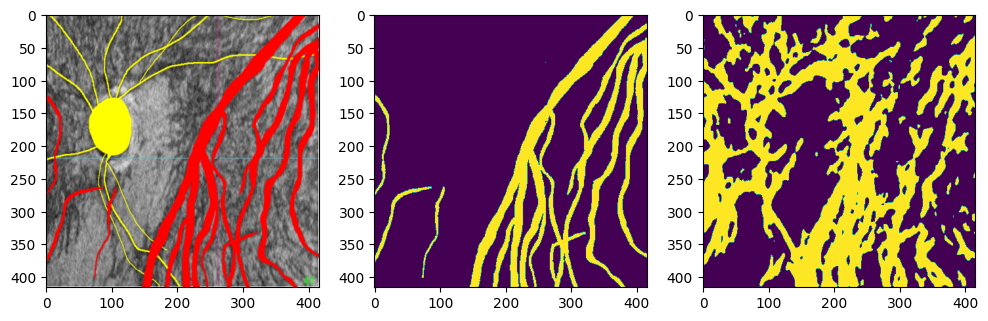

100%|██████████| 42/42 [01:31<00:00,  2.17s/it, Epoch=10, Loss=0.443439, Mean Loss=0.440009, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.4043820993976105 0.5758861488921917 0.7039222737096059 0.4872588437640423 0.9057591225050005
Model Saved


100%|██████████| 42/42 [01:20<00:00,  1.92s/it, Epoch=20, Loss=0.427942, Mean Loss=0.403933, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.41934120713518586 0.5908955577800618 0.6809755470345488 0.5218630912582218 0.9142915229914993
Model Saved


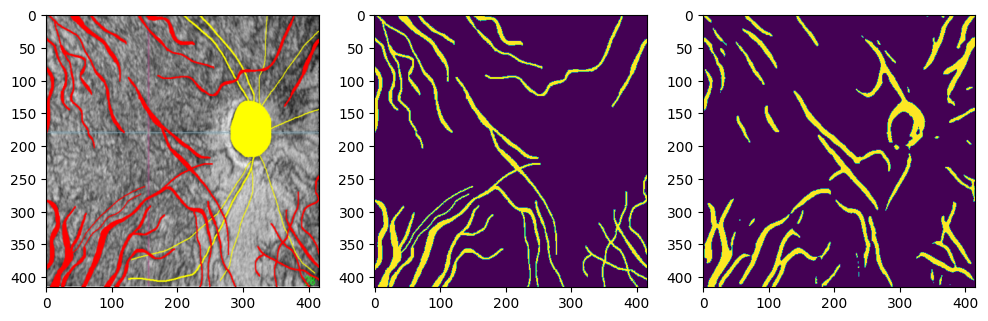

100%|██████████| 42/42 [01:34<00:00,  2.24s/it, Epoch=30, Loss=0.428609, Mean Loss=0.383895, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.3924125890067232 0.5636441268986954 0.6905192378084378 0.4761558646834732 0.9028192127989833


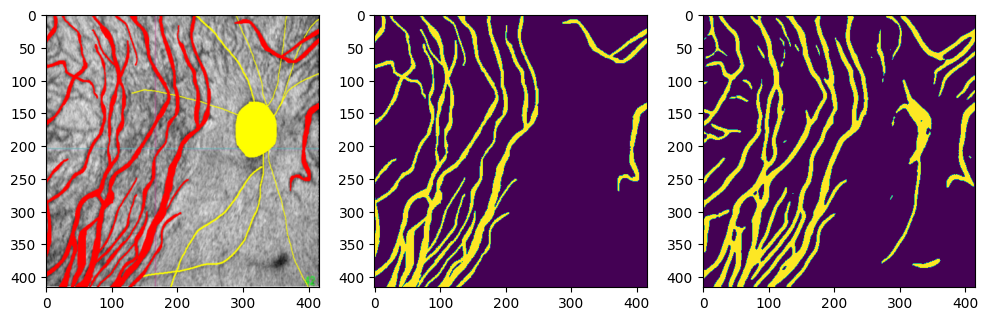

100%|██████████| 42/42 [01:33<00:00,  2.23s/it, Epoch=40, Loss=0.358688, Mean Loss=0.371905, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.4193842670447676 0.5909383058302422 0.6696303151729873 0.5287964704741039 0.9157343515605467
Model Saved


100%|██████████| 42/42 [01:34<00:00,  2.25s/it, Epoch=50, Loss=0.374283, Mean Loss=0.363234, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.4015945880267484 0.5730538508887054 0.7315732432109121 0.47099689121464916 0.9009158315276273


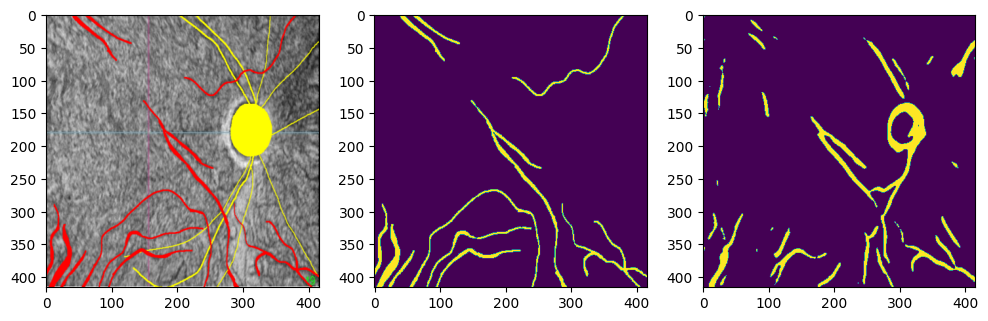

100%|██████████| 42/42 [01:32<00:00,  2.19s/it, Epoch=60, Loss=0.372476, Mean Loss=0.356524, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.3929603731940627 0.5642089764448981 0.533471952906355 0.5987044999834193 0.9250936438713643


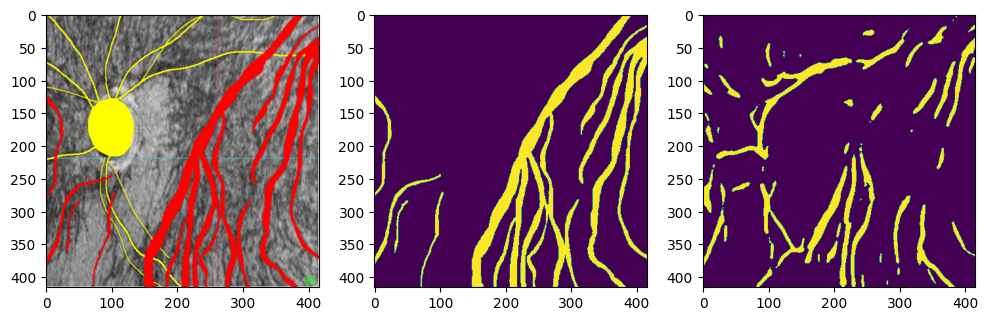

100%|██████████| 42/42 [01:21<00:00,  1.93s/it, Epoch=70, Loss=0.366707, Mean Loss=0.351098, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.40734241132492316 0.5788817391517908 0.6795885752925982 0.504169844662276 0.9101270320703808


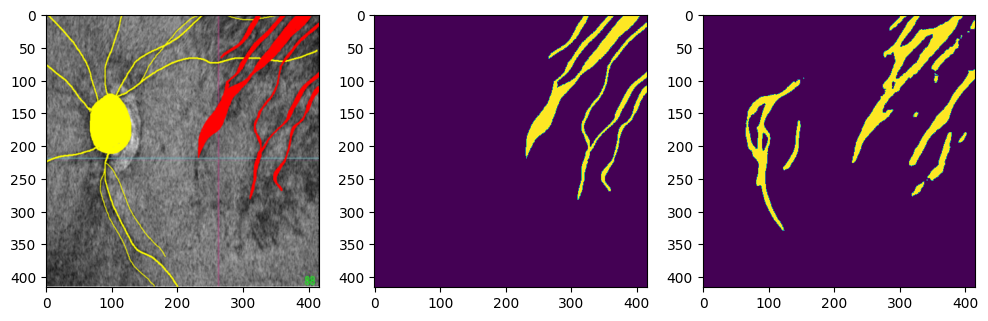

100%|██████████| 42/42 [01:23<00:00,  1.99s/it, Epoch=80, Loss=0.359697, Mean Loss=0.344747, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.4070904974467383 0.5786273138585355 0.6907812313085635 0.4978046968723996 0.9085514613196933


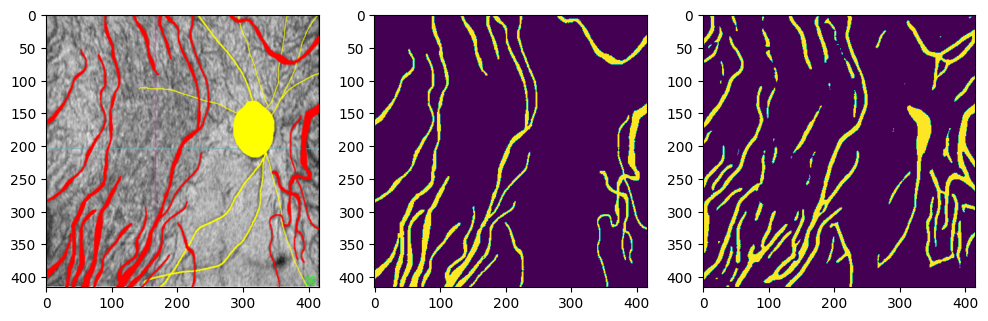

100%|██████████| 42/42 [01:27<00:00,  2.09s/it, Epoch=90, Loss=0.348631, Mean Loss=0.342190, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.4000406009641582 0.5714699997823841 0.6560293962795849 0.5062203514361412 0.9105706888334445


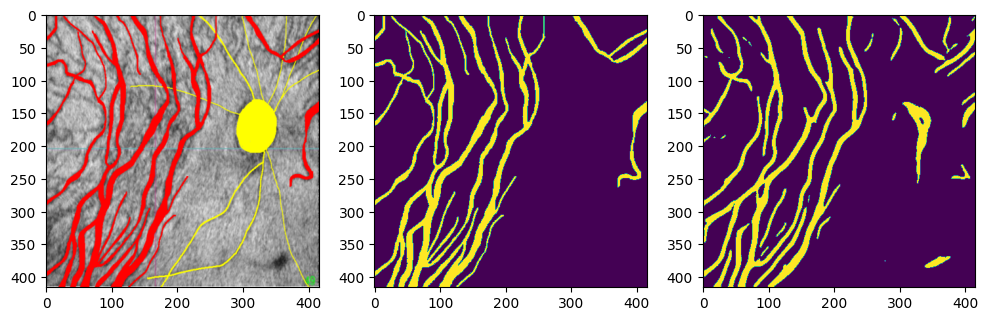

100%|██████████| 42/42 [01:28<00:00,  2.11s/it, Epoch=100, Loss=0.307310, Mean Loss=0.337303, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.3996745480896395 0.5710964004241407 0.6141501919375485 0.5336835636534192 0.9161518179900409


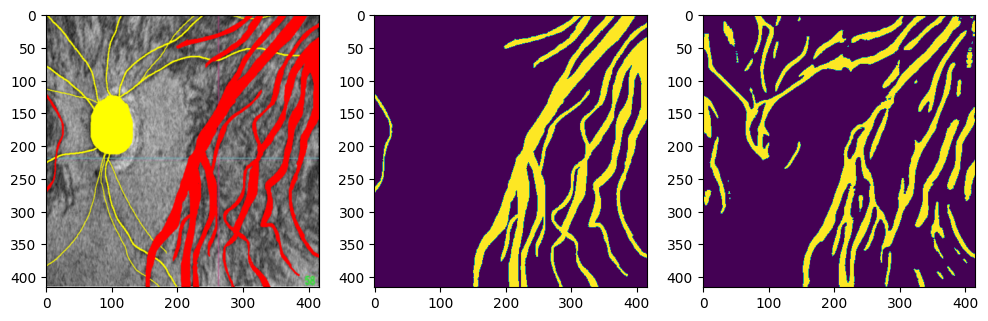

100%|██████████| 42/42 [01:30<00:00,  2.15s/it, Epoch=110, Loss=0.342483, Mean Loss=0.336850, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.40321850854671504 0.5747052309968749 0.627654586909852 0.5299945411132803 0.91556269012001


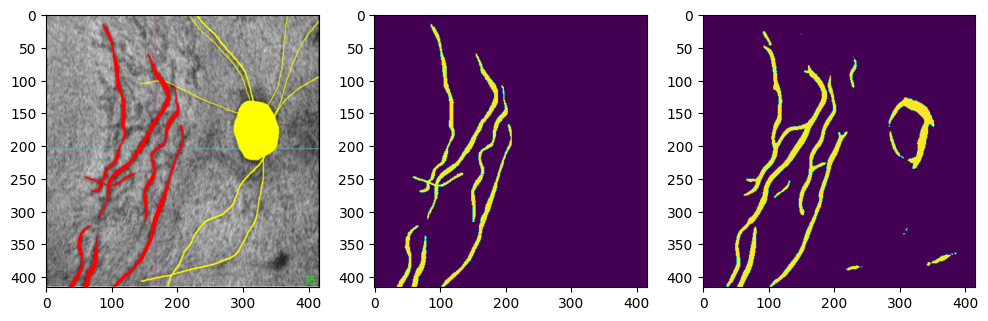

100%|██████████| 42/42 [01:27<00:00,  2.08s/it, Epoch=120, Loss=0.320869, Mean Loss=0.330979, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.4096113387194802 0.5811691882268477 0.6018889677635174 0.5618284746474419 0.9211464562151013


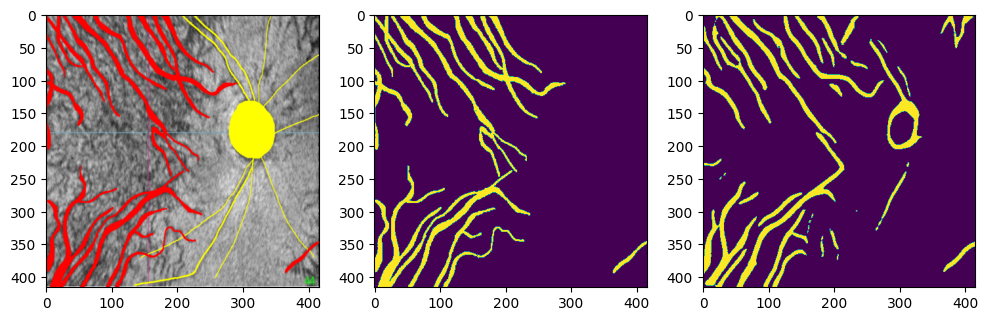

100%|██████████| 42/42 [01:29<00:00,  2.12s/it, Epoch=130, Loss=0.309090, Mean Loss=0.328907, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.39648449276027137 0.5678322886014806 0.5711436813184845 0.5645590723136593 0.9209782944151595


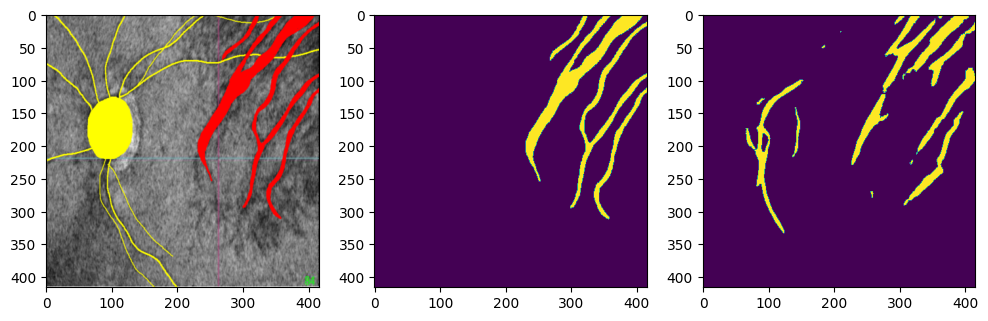

100%|██████████| 42/42 [01:18<00:00,  1.87s/it, Epoch=140, Loss=0.322465, Mean Loss=0.326512, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.40016811587354095 0.571600097640965 0.6065754817062994 0.5404382147515546 0.9173561175670889


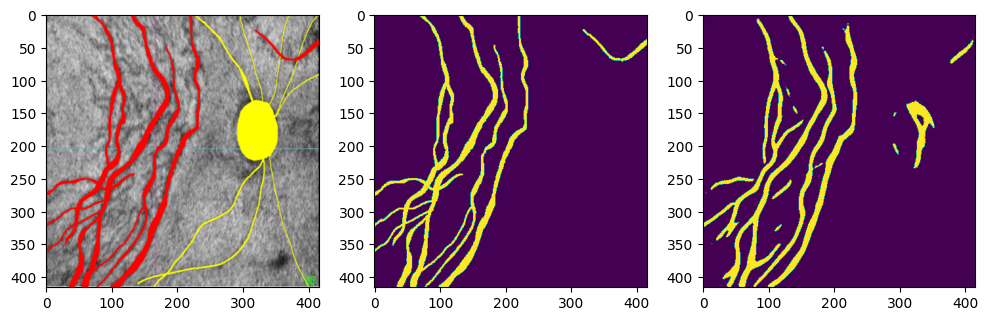

100%|██████████| 42/42 [01:28<00:00,  2.11s/it, Epoch=150, Loss=0.359391, Mean Loss=0.325492, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.401267828018512 0.5727211029827638 0.607664106783035 0.5415782859357249 0.9175860683702809


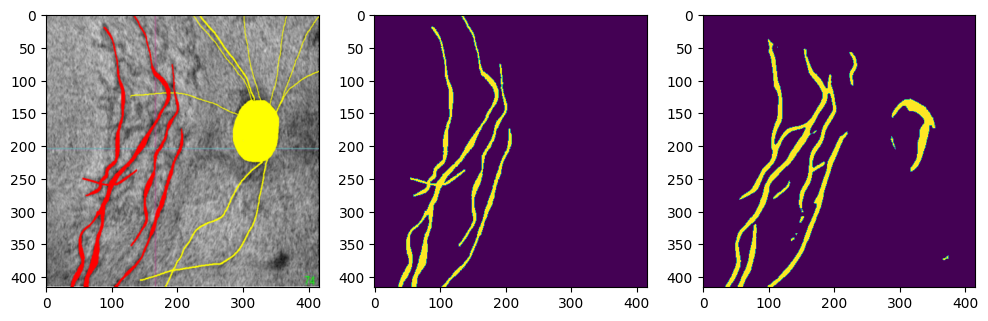

100%|██████████| 42/42 [01:32<00:00,  2.21s/it, Epoch=160, Loss=0.356963, Mean Loss=0.323673, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.4031292206059546 0.5746145325543993 0.5619431071175558 0.5878706049991139 0.9243746874739561


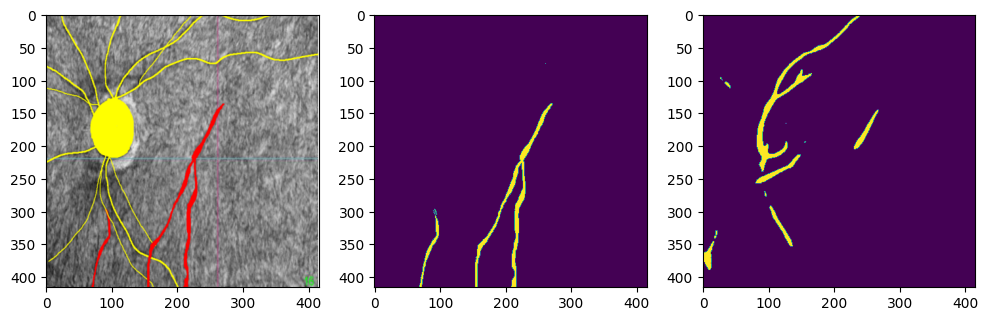

100%|██████████| 42/42 [01:26<00:00,  2.07s/it, Epoch=170, Loss=0.349404, Mean Loss=0.321388, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.39323854542756215 0.5644956446519842 0.6092690184358899 0.525852316944112 0.9145504475633386


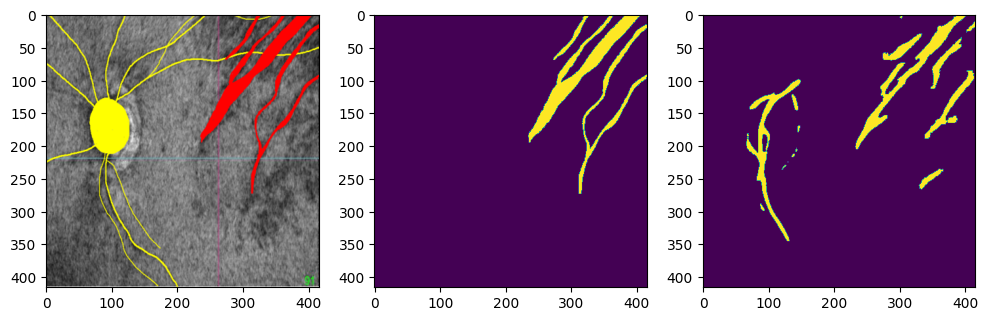

100%|██████████| 42/42 [01:28<00:00,  2.10s/it, Epoch=180, Loss=0.329760, Mean Loss=0.318944, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.3968032901190636 0.5681591573073114 0.5910890333782942 0.5469418643784414 0.9183275852414785


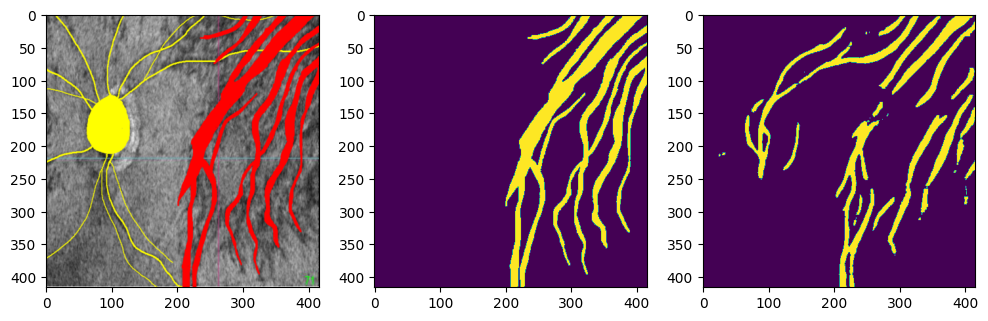

100%|██████████| 42/42 [01:27<00:00,  2.09s/it, Epoch=190, Loss=0.340116, Mean Loss=0.318420, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.38803692859296657 0.5591161453986878 0.5482522902494006 0.5704192483657391 0.9214092548076923


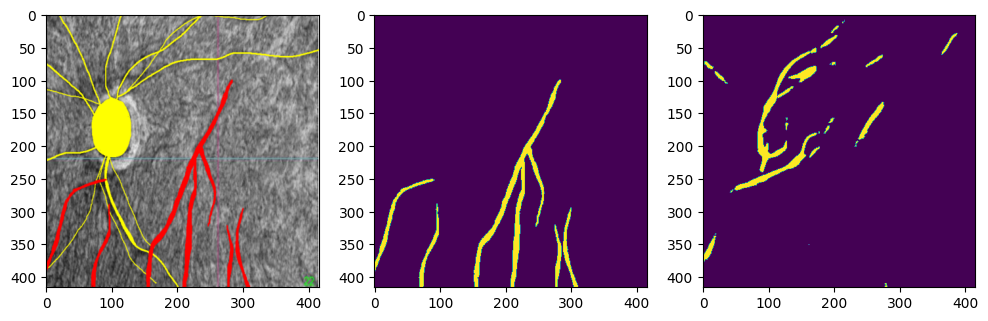

100%|██████████| 42/42 [01:27<00:00,  2.09s/it, Epoch=199, Loss=0.334072, Mean Loss=0.316666, lr=0.001000]


Testing...
jaccard, f1, recall, precision, acc
0.38873740422057573 0.5598429235637292 0.5447468064729407 0.5757995804623092 0.9221416888907409


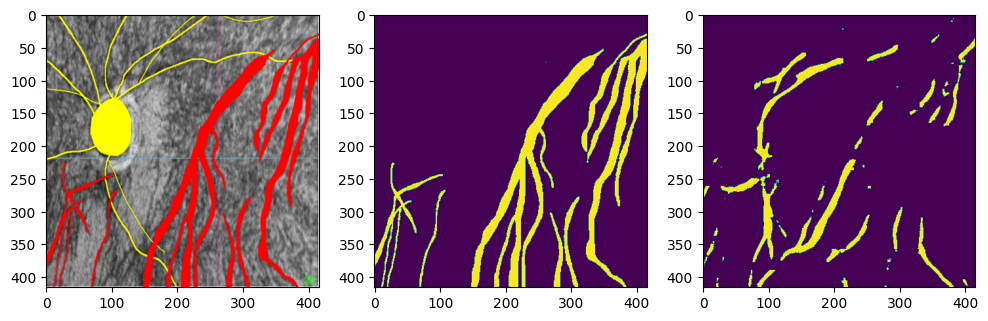

In [12]:
from tensorboardX import SummaryWriter
import datetime 

exp = 'SA_Unet'

num_epochs = args['epoch_num']
resume_epochs = args['last_epoch']
load_from = '../model/vessel_PFNet_base_b32_e500_220921_00:30.pt'


batch_size = args['train_batch_size']
scaler = torch.cuda.amp.GradScaler()
now = datetime.datetime.now()
log_name = f'{exp}_b{batch_size}_e{num_epochs}_js_'+now.strftime("%y%m%d_%H:%M")
writer = SummaryWriter(log_dir='./ckpt/PFNet/log/'+ log_name)
save_path = f'../model/vessel_{exp}_b{batch_size}_e{num_epochs}_'+ now.strftime("%y%m%d_%H:%M") + '.pt'


print(f'Using {torch.cuda.device_count()} GPUs.')
net = nn.DataParallel(net)

# net.float()
net = net.to(device)
train_loss_list = []
test_acc_list = []
test_recall_list = []
test_f1_list = []
test_iou_list = []
print(log_name)
print(save_path)
print(f'Training {num_epochs} epochs.')
if resume_epochs != 0:
    print(f'Resuming from epoch {resume_epochs}')
    net.load_state_dict(torch.load(load_from))
if args['amp'] == True:
    print("Using mixed precision.")

# print(data.shape, aug_masks[0].shape, aug_masks[1].shape, aft_mask.shape)
curr_iter = 1

for epoch in range(args['last_epoch'], args['last_epoch'] + args['epoch_num']):
    
    net.train()

    loss_running = 0
    tqdm_dataset = tqdm(train_loader)
    for batch_idx, batch in enumerate(tqdm_dataset):
        if args['poly_train']:
            base_lr = args['lr'] * (1 - float(curr_iter) / float(num_epochs)) ** args['lr_decay']
            optimizer.param_groups[0]['lr'] = 2 * base_lr
            optimizer.param_groups[1]['lr'] = 1 * base_lr

        image, masks, aft_mask, _ = batch

        labels = masks[0]
        labels = labels.unsqueeze(1)
        image, labels = image.float().to(device), labels.float().to(device)
        optimizer.zero_grad()
        

        outputs = net(image)
        loss = dice_loss(outputs, labels)
        
        loss.backward()
        # nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        optimizer.step()
        
        loss_running += loss.item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch,
            'Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(loss_running/(batch_idx+1)),
            'lr' : '{:06f}'.format(optimizer.param_groups[0]["lr"])
        })

        curr_iter += 1

    epoch_loss = loss_running / len(train_loader)
    # scheduler.step()

    writer.add_scalar('loss/Train', epoch_loss, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    train_loss_list.append(epoch_loss)

## EVAL
    if epoch % 10 == 0 or epoch == args['epoch_num']-1 :
        print("Testing...")

        images=[]
        preds=[]
        labels=[]
        label_os = []
        urls_list = []
        net.eval()
        # tqdm_loader = tqdm(test_loader)
        with torch.no_grad():
            for idx, dd in enumerate(test_loader):

                image, masks, mask_o, urls = dd 
                
                image = image.float().to(device)
                label = masks[0].float()
                label_o = masks[1].float()
                pred = net(image)    

                images.append(image.cpu().detach().numpy())
                labels.append(label.numpy())
                label_os.append(label_o)
                preds.append(pred.cpu().detach().numpy())
                urls_list.append(urls)

            images= np.array(images).squeeze(1)
            preds = np.array(preds).squeeze(1)
            labels = np.array(labels)
            label_os = np.array(label_os)
            preds = np.where(preds > 0.5 , 1 , 0)
            labels = np.where(labels > 0.5 , 1 , 0)
            
            score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)
            test_acc_list.append(score_acc)
            test_recall_list.append(score_recall)
            test_f1_list.append(score_f1)
            test_iou_list.append(score_jaccard)
            writer.add_scalar('Accuracy/Test', score_acc, epoch)
            writer.add_scalar('F1/Test', score_f1, epoch)
            writer.add_scalar('Recall/Test', score_recall, epoch)
            writer.add_scalar('Precision/Test', score_precision, epoch)
            writer.add_scalar('Jaccard/Test', score_jaccard, epoch)

            if np.max(test_iou_list) == test_iou_list[-1] or np.max(test_f1_list) == test_f1_list[-1]:
                torch.save(net.state_dict(), save_path)
                print("Model Saved")

            randnum = np.random.randint(0, 171)
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)  
            plt.imshow(label_os[randnum][0])
            plt.subplot(1, 3, 2)  
            plt.imshow(labels[randnum][0])
            plt.subplot(1, 3, 3)
            plt.imshow(preds[randnum][0])
            plt.tight_layout()
            plt.show()

# evaluation

In [14]:
print("Testing...")
net = SA_UNet(in_channels=3, num_classes=1 , base_c=16)
load_from = '/home/sklab2/workspace/code_only/junsu/model/vessel_SA_Unet_b32_e200_220930_15:31.pt'
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
net = nn.DataParallel(net)
net.load_state_dict(torch.load(load_from))
net.to(device)

images=[]
preds=[]
labels=[]
label_os = []
urls_list = []
net.eval()
# tqdm_loader = tqdm(test_loader)
with torch.no_grad():
    for idx, dd in enumerate(tqdm(test_loader)):

        image, masks, mask_o, _ = dd 
        
        image = image.float().to(device)
        label = masks[0].float()
        label_o = masks[1].float()
        pred = net(image)    

        images.append(image.cpu().detach().numpy())
        labels.append(label.numpy())
        label_os.append(label_o)
        preds.append(pred.cpu().detach().numpy())
        urls_list.append(urls)

    images= np.array(images).squeeze(1)
    preds = np.array(preds).squeeze(1)
    labels = np.array(labels)
    label_os = np.array(label_os)
    preds = np.where(preds > 0.5 , 1 , 0)
    labels = np.where(labels > 0.5 , 1 , 0)
    
    score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)

Testing...
Using 2 GPUs.


100%|██████████| 355/355 [00:30<00:00, 11.71it/s]


jaccard, f1, recall, precision, acc
0.4193842670447676 0.5909383058302422 0.6696303151729873 0.5287964704741039 0.9157343515605467


NameError: name 'test_acc_list' is not defined

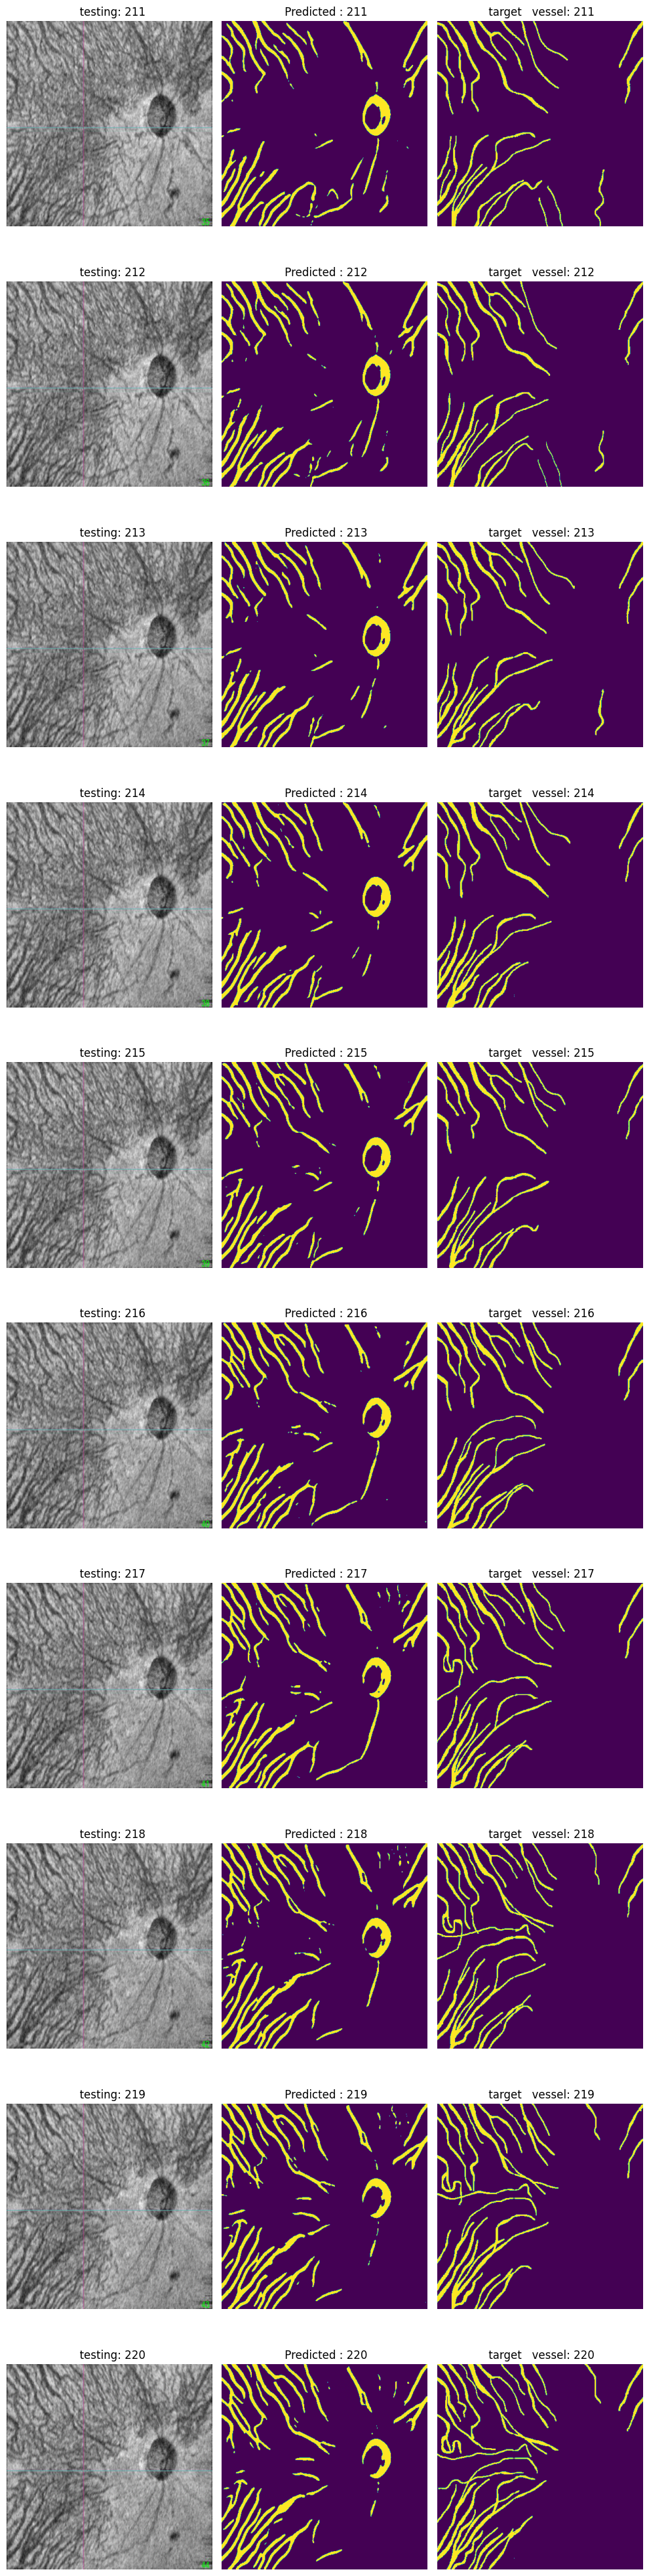

In [15]:
# randnum = np.random.randint(0, len(test_dataset)-10)
randnum=211

fig, axes = plt.subplots(10, 3, figsize = (10,40))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, target_ax , mask_ax ) in zip(range(randnum, randnum+10), axes):
    
# inputs[:10] , preds[:10], targets[:10], urls_list[:10]) :
    
    image = images[idx].astype(int).transpose(1, 2, 0) # astype(int)
    img_target = preds[idx].transpose(1, 2, 0) 
    img_mask = labels[idx].transpose(1, 2, 0)  
 
    img_ax.imshow(np.clip(image, 0, 255))

    target_ax.imshow(img_target )
    mask_ax.imshow(img_mask)

    img_ax.set_title(f'  testing: {idx}')
    target_ax.set_title(f' Predicted : {idx}')
    
    mask_ax.set_title(f' target   vessel: {idx}')
plt.tight_layout()
plt.show()
 